In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import pandas as pd
import numpy as np

In [2]:
results_dirs = {
    "mtsNFVS": "../benchmark/results-nfvs/",
    "AEON.py": "../benchmark/results-aeon/",
    "biobalm": "../benchmark/results-0.3.0/",
    "biobalm (block)": "../benchmark/results-0.3.0/",
}

nk3_fnames = {  # will make others when they are ready
    "all": "random-nk3.csv",
    "biobalm-expand": "random-nk3-full-expand.csv",
    "biobalm-search": "random-nk3-full-attractors.csv",
    "biobalm (block)": "random-nk3-block-attractors.csv",
}

nk2_fnames = {  # will make others when they are ready
    "all": "random-nk2.csv",
    "biobalm-expand": "random-nk2-full-expand.csv",
    "biobalm-search": "random-nk2-full-attractors.csv",
    "biobalm (block)": "random-nk2-block-attractors.csv",
}

ncf_fnames = {  # will make others when they are ready
    "all": "random-ncf.csv",
    "biobalm-expand": "random-ncf-full-expand.csv",
    "biobalm-search": "random-ncf-full-attractors.csv",
    "biobalm (block)": "random-ncf-block-attractors.csv",
}

dense_fnames = {  # will make others when they are ready
    "all": "random-dense.csv",
    "biobalm-expand": "random-dense-full-expand.csv",
    "biobalm-search": "random-dense-full-attractors.csv",
    "biobalm (block)": "random-dense-block-attractors.csv",
}

bbm_fnames = {  # will make others when they are ready
    "all": "bbm-inputs-true.csv",
    "biobalm-expand": "bbm-inputs-true-full-expand.csv",
    "biobalm-search": "bbm-inputs-true-full-attractors.csv",
    "biobalm (block)": "bbm-inputs-true-block-attractors.csv",
}

colors = {
    "mtsNFVS": "#DDAA33",
    "AEON.py": "#BB5566",
    "biobalm": "#004488",
    "biobalm (block)": "#66aadd",
}

In [3]:
def generate_combined_data(results_dirs, fnames_list, verbose = False):
    # df = pd.DataFrame(columns=["Benchmark ID", "mtsNFVS Time[s]", "AEON.py Time[s]", "biobalm_full_attractors Time[s]", "biobalm_block_attractors Time[s]"])
    
    dfas = {
        "mtsNFVS": [],
        "AEON.py": [],
        "biobalm (block)": [],
    }
    dfs = {}
    
    for tool, dir in results_dirs.items():
        if tool == "biobalm": # only do block expansion for now
            continue
        for fnames in fnames_list:
            if tool == "mtsNFVS":
                benchmark = fnames["all"].split(".")[0]
                dfa = pd.read_csv(dir + fnames["all"], header=None, skiprows=1, names=["Benchmark ID", "mtsNFVS Time[s]", "Notes"])
                dfa.fillna("", inplace=True)
                dfa.insert(0, "Benchmark Type", benchmark)
                
                success_rows = dfa['Notes'].str.contains(r'Number of attractors|Network solved')
                dfa.loc[~success_rows, 'mtsNFVS Time[s]'] = "inf"
                dfa["mtsNFVS Time[s]"] = dfa["mtsNFVS Time[s]"].apply(lambda x: float(x))
                
                dfa.drop("Notes", axis=1, inplace=True)
                if verbose:
                    print(tool, benchmark)
                    dfa.head()
                dfas[tool].append(dfa.copy())
                
            elif tool == "AEON.py":
                benchmark = fnames["all"].split(".")[0]
                dfa = pd.read_csv(dir + fnames["all"], header=None, skiprows=1, names=["Benchmark ID", "AEON.py Time[s]", "Attractors", "Attractor states"])
                dfa.fillna("", inplace=True)
                dfa.insert(0, "Benchmark Type", benchmark)
                
                success_rows = dfa['Attractors'].str.match(r'^\s*\d+$')
                dfa.loc[~success_rows, 'AEON.py Time[s]'] = float("inf")
                dfa["AEON.py Time[s]"] = dfa["AEON.py Time[s]"].apply(lambda x: float(x))
                
                dfa.drop(["Attractors", "Attractor states"], axis=1, inplace=True)
                if verbose:
                    print(tool, benchmark)
                    dfa.head()
                dfas[tool].append(dfa.copy())
                
            elif tool == "biobalm (block)":
                benchmark = fnames["biobalm (block)"].split("-block")[0]
                dfa = pd.read_csv(
                    dir + fnames["biobalm (block)"],
                    header=None,
                    skiprows=1,
                    names=["Benchmark ID", "biobalm Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
                )
                dfa.insert(0, "Benchmark Type", benchmark)
                # The benchmark is a success if "Attractors" is defined.
                success_rows = ~dfa['Attractors'].isna()
                dfa.loc[~success_rows, 'biobalm Time[s]'] = float("inf")
                dfa["biobalm Time[s]"] = dfa["biobalm Time[s]"].apply(lambda x: float(x))
                dfa.drop(["All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"], axis=1, inplace=True)
                if verbose:
                    print(tool, benchmark)
                    dfa.head()
                dfas[tool].append(dfa.copy())
            
        
        if dfas[tool]:
            dfs[tool] = pd.concat(dfas[tool])

    df = pd.merge(dfs["mtsNFVS"], dfs["AEON.py"], on=("Benchmark ID", "Benchmark Type"), how = "outer").merge(dfs["biobalm (block)"], on=("Benchmark ID", "Benchmark Type"), how = "outer")
    return df
             
dfc = generate_combined_data(results_dirs, [nk3_fnames, nk2_fnames, ncf_fnames, dense_fnames, bbm_fnames])


# sorted(dfc["Benchmark ID"].apply(lambda x: int(x.split("_")[0][1:]) if x.split("_")[-1]=="nk3" else 0).unique())
# dfc[dfc["AEON.py Time[s]"].isna()]["Benchmark ID"].to_list()

# AEON.py did not complete for NK3 models size 640 or larger
dfc["AEON.py Time[s]"].fillna(float("inf"), inplace=True)
dfc


,Benchmark Type,Benchmark ID,mtsNFVS Time[s],AEON.py Time[s],biobalm Time[s]
0,random-nk3,n10_0,0.65,0.01,0.18
1,random-nk3,n10_1,0.57,0.01,0.10
2,random-nk3,n10_10,0.04,0.01,0.09
3,random-nk3,n10_100,0.56,0.01,0.17
4,random-nk3,n10_101,0.62,0.01,0.10
...,...,...,...,...,...
4565,bbm-inputs-true,208,0.31,0.01,0.14
4566,bbm-inputs-true,209,0.93,247.99,0.50
4567,bbm-inputs-true,210,1.90,inf,0.33
4568,bbm-inputs-true,211,16.61,inf,6.00


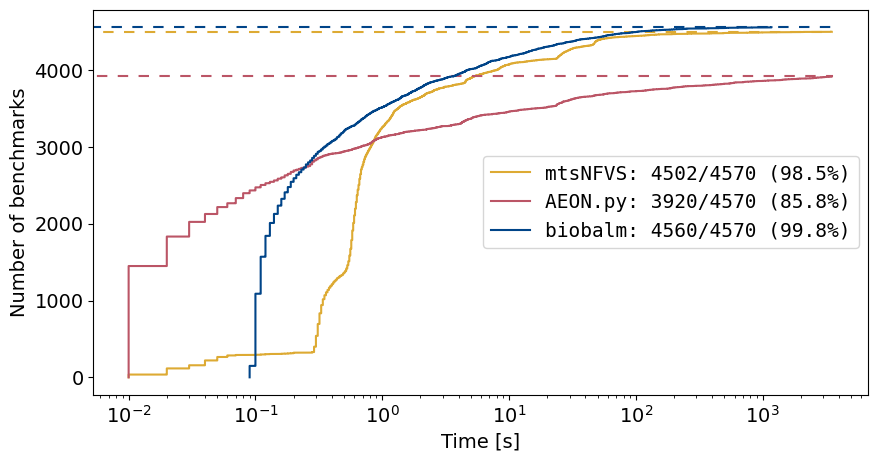

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.set_facecolor("white")
for i, column in enumerate(dfc.columns[2:]):
    tool = column.split(" Time[s]")[0]
    t = dfc[column].sort_values()
    successes = sum(t < float("inf"))
    attempts = len(t)
    ax.hlines(
        y=successes,
        xmin=0,
        xmax=3600,
        color=colors[tool],
        linestyle=(i * 3, (5, 5)),
    )
    ax.step(t, np.arange(len(t)), label=f'{tool}: {successes}/{attempts} ({successes/attempts:.1%})', c=colors[tool])
    
ax.set_xscale("log")
ax.set_xlabel("Time [s]", fontsize=14)
ax.set_ylabel("Number of benchmarks", fontsize=14)


ax.tick_params(labelsize=14)
ax.legend(loc="center right", prop={'family': 'monospace', 'size': 14})

fig.savefig("./figures/combined_completion_benchmarks.pdf", bbox_inches="tight")

In [105]:
dfc['Benchmark Type'].unique()

array(['random-nk3', 'random-nk2', 'random-ncf', 'random-dense',
       'bbm-inputs-true'], dtype=object)

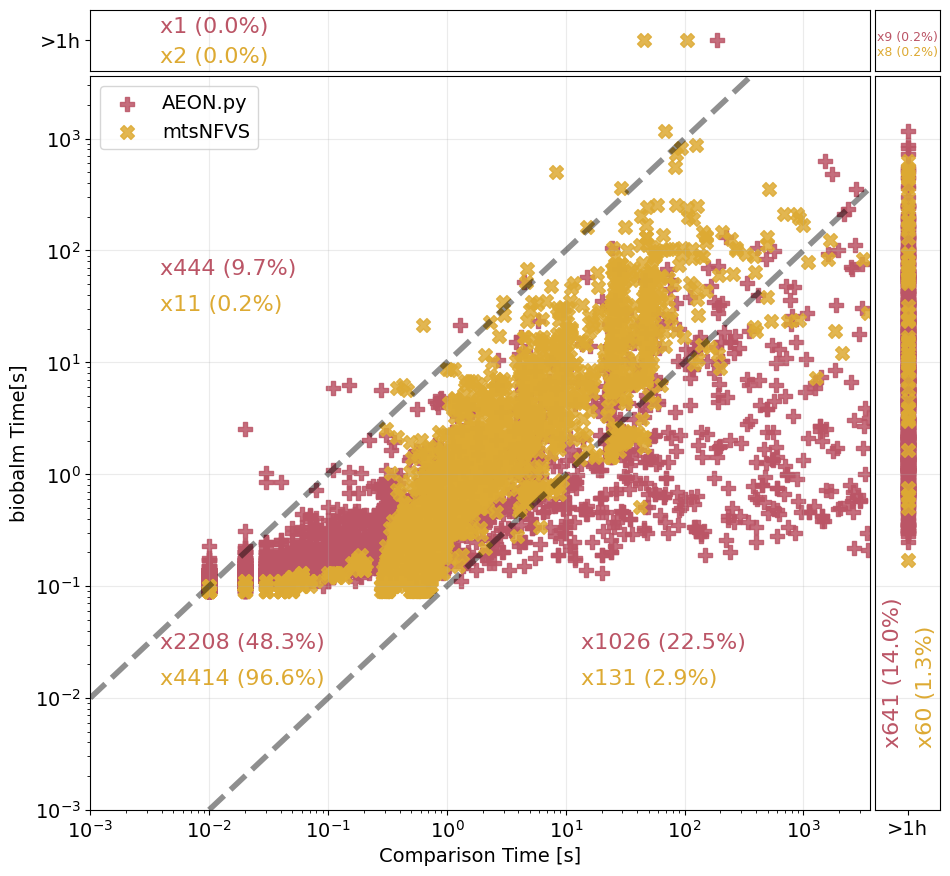

In [148]:
LOG_MODE = True

stretch_factor = 12
fig = plt.figure(figsize=(10, 10))

fig.set_facecolor("white")
figs = fig.subfigures(1, 1)
afig = figs
axd = afig.subplot_mosaic(
        [
            ["BBTimeout", "BothTimeout"],
            ["BothRan", "CompTimeout"],
        ],
        gridspec_kw={
            "width_ratios": [stretch_factor, 1],
            "height_ratios": [1, stretch_factor],
        },
    )
for ti, tool in enumerate(["AEON.py Time[s]","mtsNFVS Time[s]"]):
    color = colors[tool.split(" ")[0]]
    marker = "X" if tool.split(" ")[0] == "mtsNFVS" else "P"
    size = 100
    alpha = 0.85
    ga = 0.25
    
    t_bb, t = dfc['biobalm Time[s]'], dfc[tool]
    axd["BothRan"].scatter(
        t,
        t_bb,
        alpha=alpha,
        c = color,
        s=size,
        marker = marker,
        label=tool.split(" ")[0],
    )

    if LOG_MODE:
        tmax = 3600
        tmin = 0.001
    else:    
        tmax = 3600
        tmin = 0
    
    axd["BothRan"].set_xlim(tmin, tmax)
    axd["BothRan"].set_ylim(tmin, tmax)
    
    if LOG_MODE:
        axd["BothRan"].set_xscale("log")
        axd["BothRan"].set_yscale("log")

    axd["BothRan"].set_xlabel(f"Comparison Time [s]", fontsize=14)
    axd["BothRan"].set_ylabel("biobalm Time[s]", fontsize=14)
    axd["BothRan"].tick_params(labelsize=14, gridOn=True, grid_alpha=ga)

    if LOG_MODE:
        boundary_pts = np.logspace(np.log10(tmin), np.log10(tmax), 100)
    else:
        boundary_pts = np.linspace(tmin, tmax, 100)
    axd["BothRan"].plot(
        boundary_pts,
        boundary_pts*10,
        color="black",
        linestyle="--",
        linewidth=4,
        alpha=0.25,
    )
    axd["BothRan"].plot(
        boundary_pts*10,
        boundary_pts,
        color="black",
        linestyle="--",
        linewidth=4,
        alpha=0.25,
    )

    axd["BBTimeout"].scatter(
        t[t_bb == float("inf")],
        0 * t[t_bb == float("inf")],
        c = color,
        alpha=alpha,
        s=size,
        marker = marker,
    )
    axd["BBTimeout"].sharex(axd["BothRan"])
    if LOG_MODE:
        axd["BBTimeout"].set_xscale("log")
    axd["BBTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )
    axd["BBTimeout"].tick_params(axis="x", gridOn=True, grid_alpha=ga)
    axd["BBTimeout"].tick_params(axis="y", tick1On=True, labelleft=True)
    axd["BBTimeout"].set_yticks([0])
    axd["BBTimeout"].set_yticklabels([">1h"], fontsize=14)

    axd["CompTimeout"].scatter(
        0 * t_bb[t == float("inf")],
        t_bb[t == float("inf")],
        c = color,
        alpha=alpha,
        s=size,
        marker = marker,
    )
    axd["CompTimeout"].sharey(axd["BothRan"])
    if LOG_MODE:
        axd["CompTimeout"].set_yscale("log")
    axd["CompTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )
    axd["CompTimeout"].tick_params(axis="y", gridOn=True, grid_alpha=ga)
    axd["CompTimeout"].tick_params(axis="x", tick1On=True, labelbottom=True)
    axd["CompTimeout"].set_xticks([0])
    axd["CompTimeout"].set_xticklabels([">1h"], fontsize=14)

    bti = (t == float("inf")) & (t_bb == float("inf"))
    # axd["BothTimeout"].scatter(
    #     0,
    #     1-ti,
    #     c = color,
    #     alpha=alpha,
    #     s=18*size,
    #     marker = marker,
    # )
    
    axd["BothTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )
    axd["BothTimeout"].set_ylim(-.5, 1.5)
    
    
    axd["BothRan"].legend(loc="upper left", fontsize=14)
    
    
    slow_count = sum(((10*t)<t_bb) & (t_bb < float("inf")))
    fast_count = sum(((10*t_bb)<t) & (t_bb < float("inf")))
    same_count = sum(((10*t_bb)>t) & ((t_bb<(10*t))))
    
    axd["BothRan"].annotate(f"x{slow_count} ({slow_count/len(t)*100:.1f}%)", xy=(0.09, 0.73-ti/20), xycoords="axes fraction", fontsize=16, color=color)
    axd["BothRan"].annotate(f"x{fast_count} ({fast_count/len(t)*100:.1f}%)", xy=(0.63, 0.22-ti/20), xycoords="axes fraction", fontsize=16, color=color)
    axd["BothRan"].annotate(f"x{same_count} ({same_count/len(t)*100:.1f}%)", xy=(0.09, 0.22-ti/20), xycoords="axes fraction", fontsize=16, color=color)
    
    very_slow_count = sum((t_bb == float("inf")) & (t < float("inf")))
    very_fast_count = sum((t == float("inf")) & (t_bb < float("inf")))
    
    axd["BBTimeout"].annotate(f"x{very_slow_count} ({very_slow_count/len(t)*100:.1f}%)", xy=(0.09, 0.63-ti/2), xycoords="axes fraction", fontsize=16, color=color)
    axd["CompTimeout"].annotate(f"x{very_fast_count} ({very_fast_count/len(t)*100:.1f}%)", xy=(0.12+ti/2, 0.09), rotation=90, xycoords="axes fraction", fontsize=16, color=color)

    axd["BothTimeout"].annotate(f"x{sum(bti)} ({sum(bti)/len(t)*100:.1f}%)", xy=(0.03, 0.5-ti/4), rotation=0, xycoords="axes fraction", fontsize=9, color=color)

    afig.subplots_adjust(hspace=0.0135, wspace=0.0135)

fig.subplots_adjust(bottom=0.08, left=0.05)
fig.savefig("./figures/combined_time_scatter_benchmarks.pdf", bbox_inches="tight")

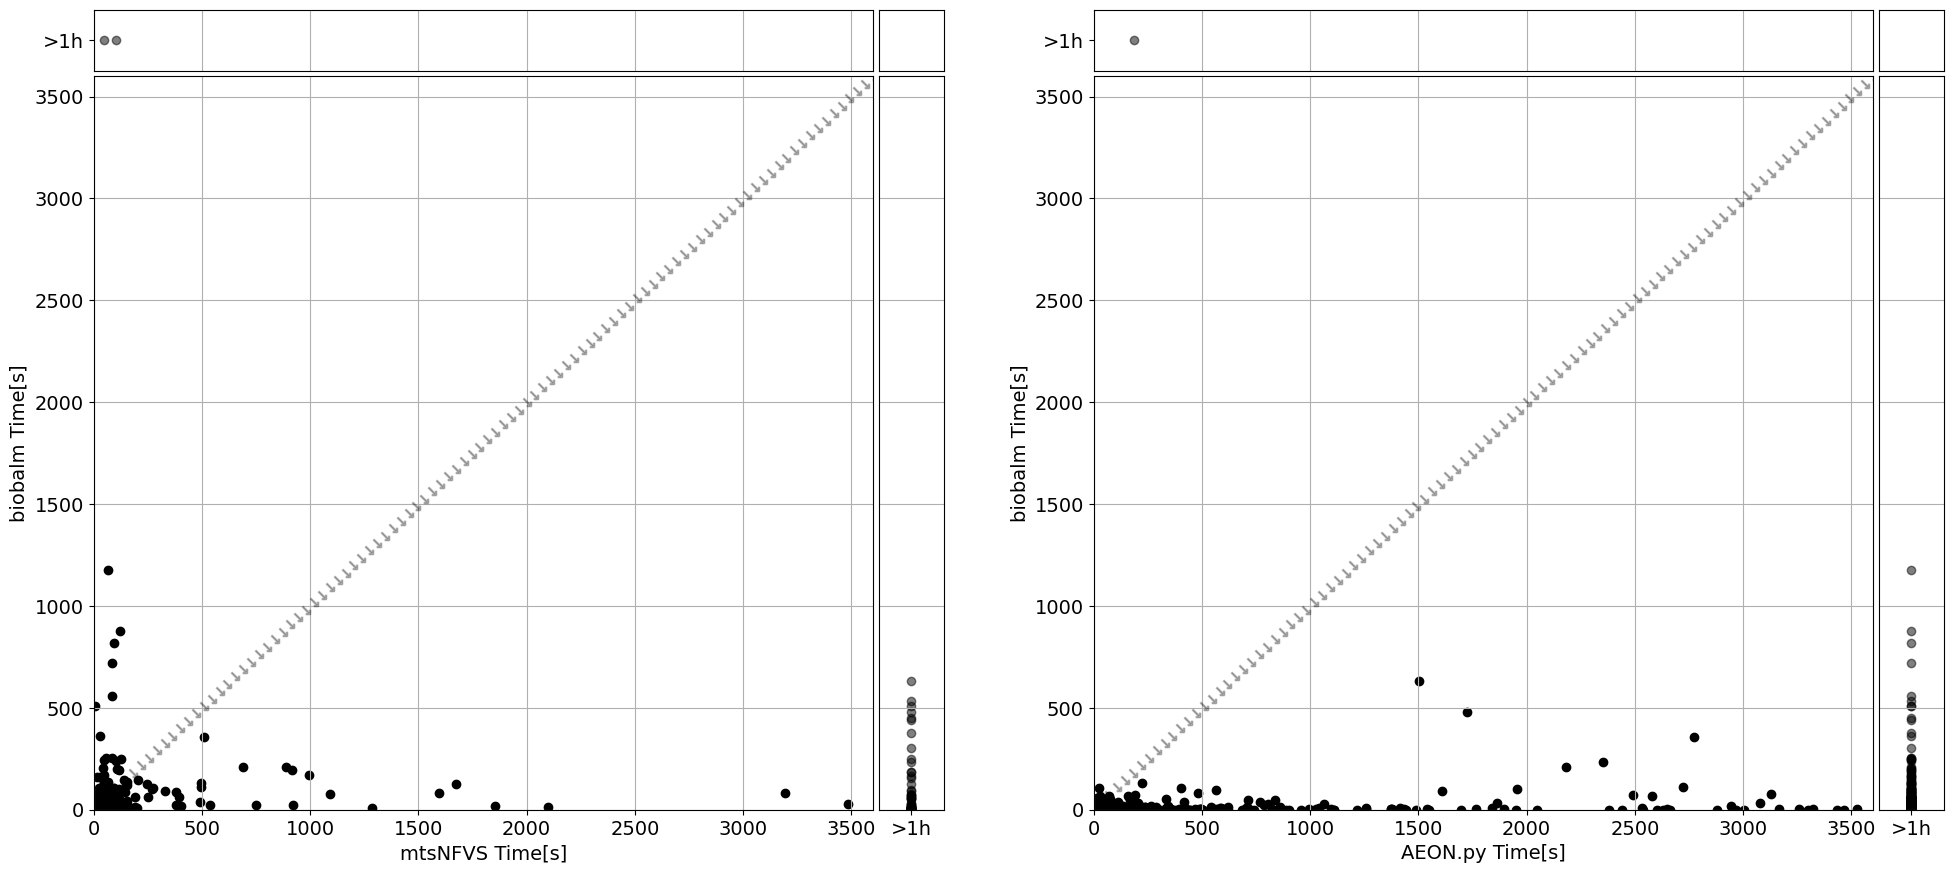

In [129]:
LOG_MODE = False

# This looks like confetti; no color is probably better
# ensemble_color_map = {
#     'random-nk3': "#4477aa",
#     'random-nk2': "#66ccee",
#     'random-ncf': "#228833",
#     'random-dense': 'purple',
#     'bbm-inputs-true': "#ee6677",
# }
# ensemble_colors = dfc['Benchmark Type'].apply(lambda x: ensemble_color_map[x])
stretch_factor = 12
fig = plt.figure(figsize=(20, 10))

fig.set_facecolor("white")
figs = fig.subfigures(1, 2)
for afig, tool in zip(figs.flatten(), ["mtsNFVS Time[s]", "AEON.py Time[s]"]):
    axd = afig.subplot_mosaic(
        [
            ["BBTimeout", "BothTimeout"],
            ["BothRan", "CompTimeout"],
        ],
        gridspec_kw={
            "width_ratios": [stretch_factor, 1],
            "height_ratios": [1, stretch_factor],
        },
    )
    
    t_bb, t = dfc['biobalm Time[s]'], dfc[tool]
    axd["BothRan"].scatter(
        t,
        t_bb,
        alpha=1,
        c = 'k',
        # c = ensemble_colors,
    )

    if LOG_MODE:
        tmax = max(t[t < float("inf")].max(), t_bb[t_bb < float("inf")].max()) * 10.0
        tmin = min(t[t < float("inf")].min(), t_bb[t_bb < float("inf")].min()) / 10.0
    else:    
        tmax = 3600
        tmin = 0
    
    axd["BothRan"].set_xlim(tmin, tmax)
    axd["BothRan"].set_ylim(tmin, tmax)
    
    if LOG_MODE:
        axd["BothRan"].set_xscale("log")
        axd["BothRan"].set_yscale("log")

    axd["BothRan"].set_xlabel(f"{tool}", fontsize=14)
    axd["BothRan"].set_ylabel("biobalm Time[s]", fontsize=14)
    axd["BothRan"].tick_params(labelsize=14, gridOn=True)

    if LOG_MODE:
        boundary_pts = np.logspace(np.log10(tmin), np.log10(tmax), 100)
    else:
        boundary_pts = np.linspace(tmin, tmax, 100)
    axd["BothRan"].plot(
        boundary_pts,
        boundary_pts,
        color="black",
        linestyle="",
        marker=r"$\searrow$",
        alpha=0.25,
    )

    axd["BBTimeout"].scatter(
        t[t_bb == float("inf")],
        0 * t[t_bb == float("inf")],
        c = 'k',
        alpha=0.5,
    )
    axd["BBTimeout"].sharex(axd["BothRan"])
    if LOG_MODE:
        axd["BBTimeout"].set_xscale("log")
    axd["BBTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )
    axd["BBTimeout"].tick_params(axis="x", gridOn=True)
    axd["BBTimeout"].tick_params(axis="y", tick1On=True, labelleft=True)
    axd["BBTimeout"].set_yticks([0])
    axd["BBTimeout"].set_yticklabels([">1h"], fontsize=14)

    axd["CompTimeout"].scatter(
        0 * t_bb[t == float("inf")],
        t_bb[t == float("inf")],
        c = 'k',
        alpha=0.5,
    )
    axd["CompTimeout"].sharey(axd["BothRan"])
    if LOG_MODE:
        axd["CompTimeout"].set_yscale("log")
    axd["CompTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )
    axd["CompTimeout"].tick_params(axis="y", gridOn=True)
    axd["CompTimeout"].tick_params(axis="x", tick1On=True, labelbottom=True)
    axd["CompTimeout"].set_xticks([0])
    axd["CompTimeout"].set_xticklabels([">1h"], fontsize=14)

    axd["BothTimeout"].scatter(
        0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
        0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
        alpha=0.5,
    )
    axd["BothTimeout"].tick_params(
        which="both",
        labelbottom=False,
        labelleft=False,
        tick1On=False,
        tick2On=False,
    )

    afig.subplots_adjust(hspace=0.0135, wspace=0.0135)

fig.subplots_adjust(bottom=0.08, left=0.05)

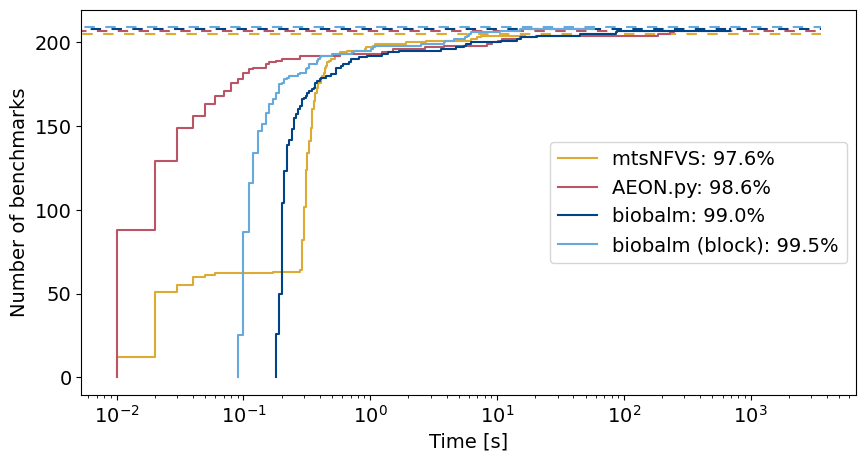

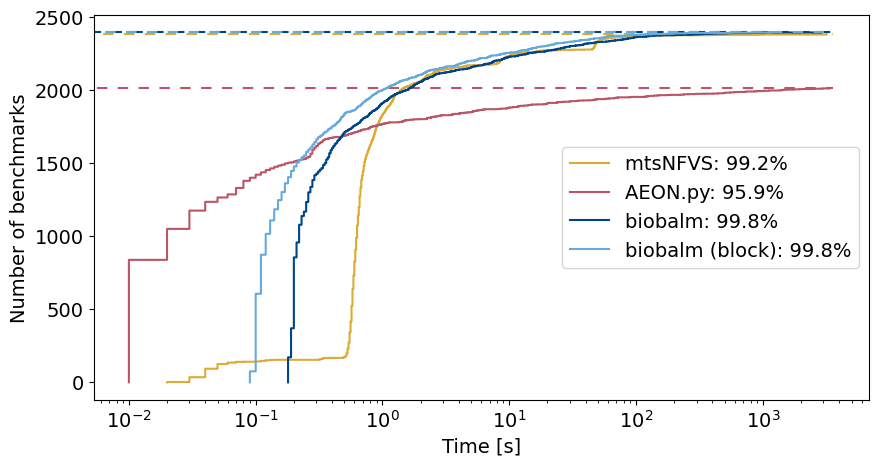

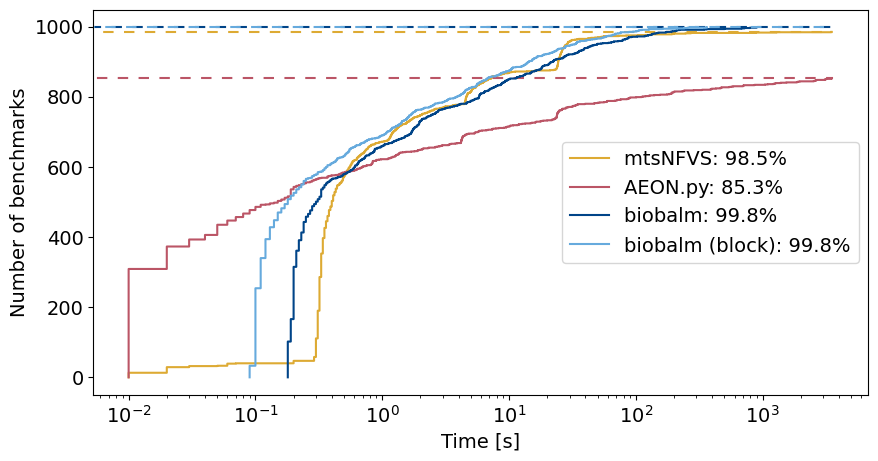

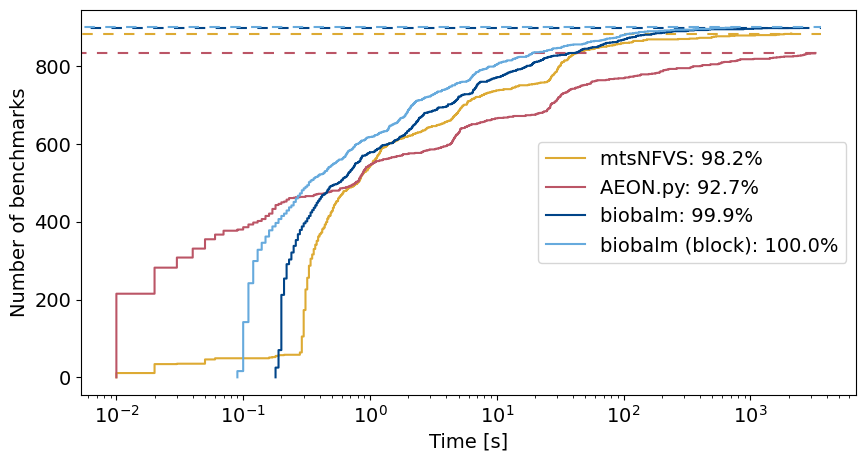

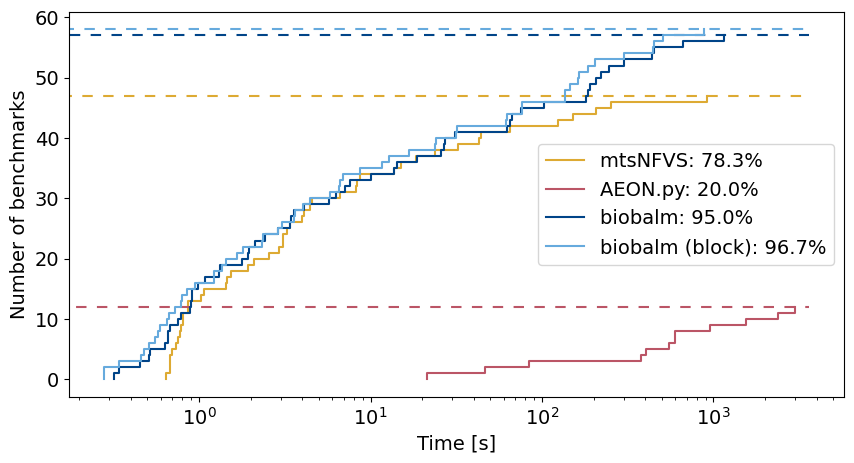

In [10]:
def plot_cumulative(dirs, fnames, colors, verbose = False):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.set_facecolor("white")

    for i, (tool, dir) in enumerate(dirs.items()):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            ) 
            df.fillna("", inplace=True)
            # The benchmark is a success if the note contains one of two pre-defined values.
            success_rows = df['Notes'].str.contains(r'Number of attractors|Network solved')
            if verbose:
                print("Success rate for mtsNFVS:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = "inf"
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "AEON.py":            
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Attractors", "Attractor states"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if "Attractors" is exactly one number.
            success_rows = df['Attractors'].str.match(r'^\s*\d+$')
            if verbose:
                print("Success rate for AEON:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm (block)":
            df = pd.read_csv(
                dirs[tool] + fnames["biobalm (block)"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined.
            success_rows = ~df['Attractors'].isna()
            if verbose:
                print("Success rate for biobalm(block):", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps"],
            )
            success_rows = ~df_exp['Minimal traps'].isna()
            df_exp.loc[~success_rows, 'Time[s]'] = float("inf")
            df_exp["Time[s]"] = df_exp["Time[s]"].apply(lambda x: float(x))
            
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined (if expansion failed, 
            # this will fail too, so no need to check both).
            success_rows = ~df_att['Attractors'].isna()
            df_att.loc[~success_rows, 'Time[s]'] = float("inf")
            df_att["Time[s]"] = df_att["Time[s]"].apply(lambda x: float(x))
            
            if verbose:
                print("Success rate for biobalm:", success_rows.value_counts())
            
            t = (df_exp["Time[s]"] + df_att["Time[s]"]).sort_values()            
        else:
            print(f"SKIPPING {tool}")
            continue
        successes = sum(t < float("inf"))
        attempts = len(t)
        ax.hlines(
            y=successes,
            xmin=0,
            xmax=3600,
            color=colors[tool],
            linestyle=(i * 3, (5, 5)),
        )
        ax.step(t, np.arange(len(t)), label=f'{tool}: {successes/attempts:.1%}', c=colors[tool])

    ax.set_xscale("log")

    ax.set_xlabel("Time [s]", fontsize=14)
    #ax.set_xlim([1, 3600])
    ax.set_ylabel("Number of benchmarks", fontsize=14)
    #ax.set_ylim([1800,2500])

    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="center right")


plot_cumulative(results_dirs, bbm_fnames, colors)
plot_cumulative(results_dirs, nk3_fnames, colors)
plot_cumulative(results_dirs, nk2_fnames, colors)
plot_cumulative(results_dirs, ncf_fnames, colors)
plot_cumulative(results_dirs, dense_fnames, colors)


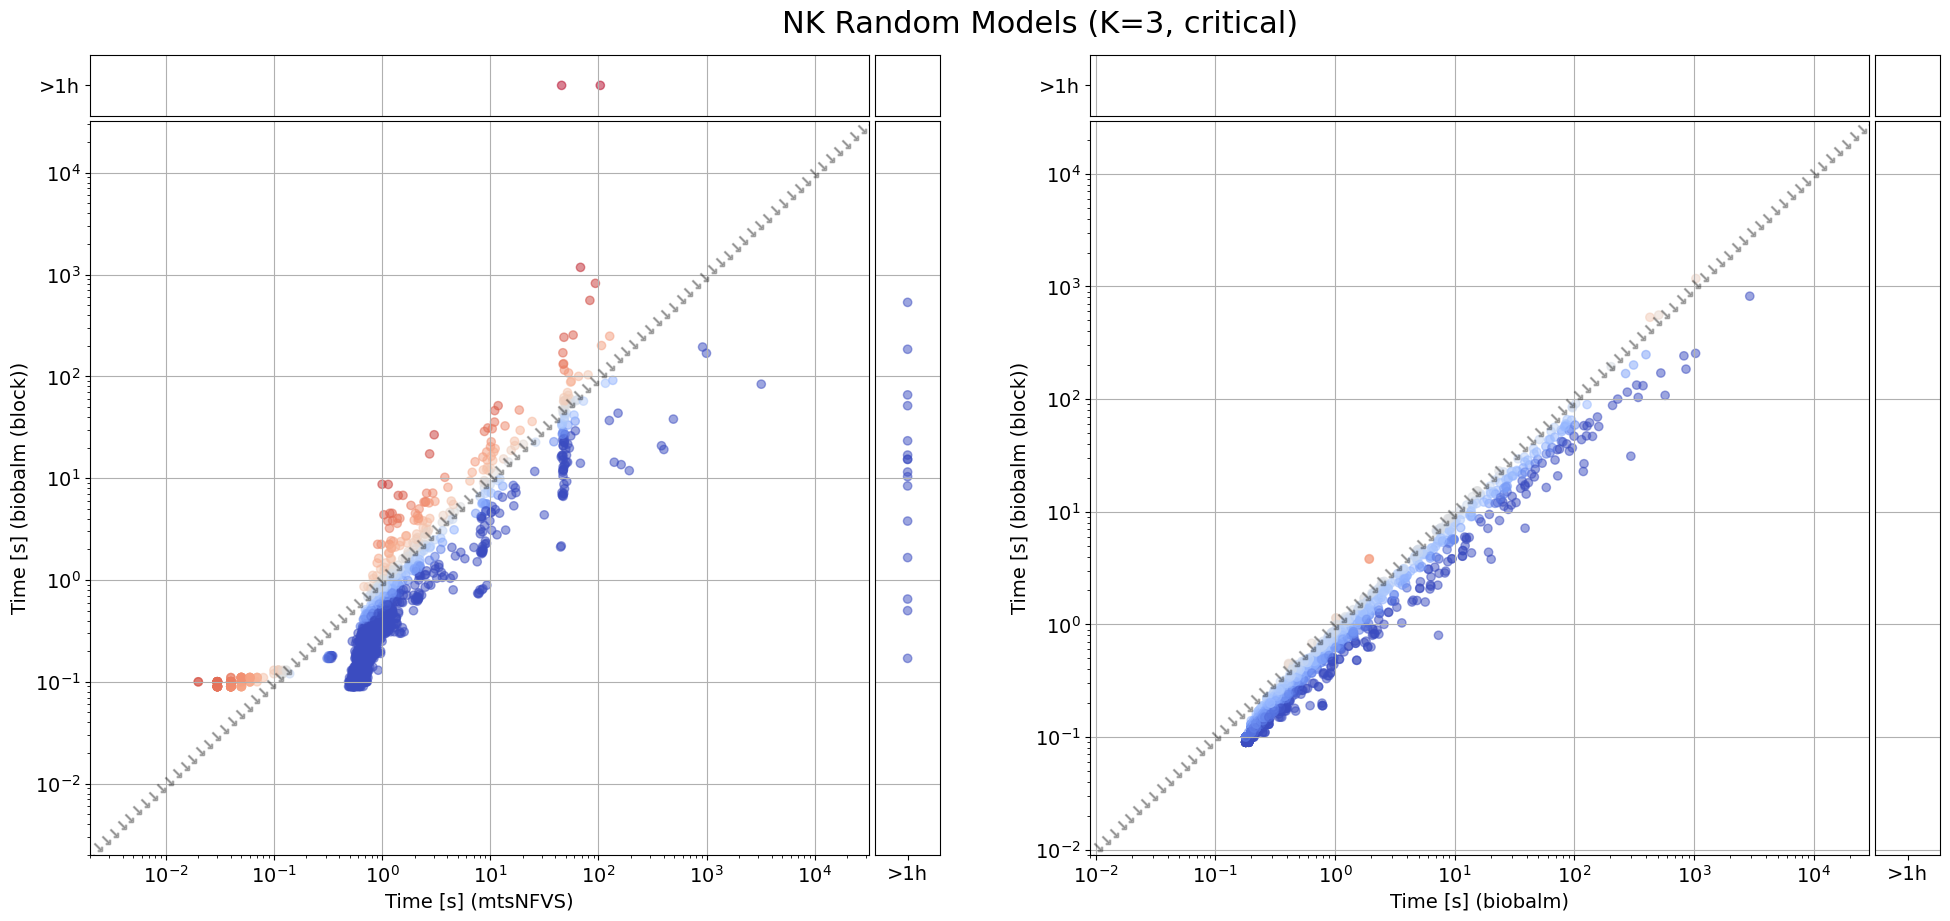

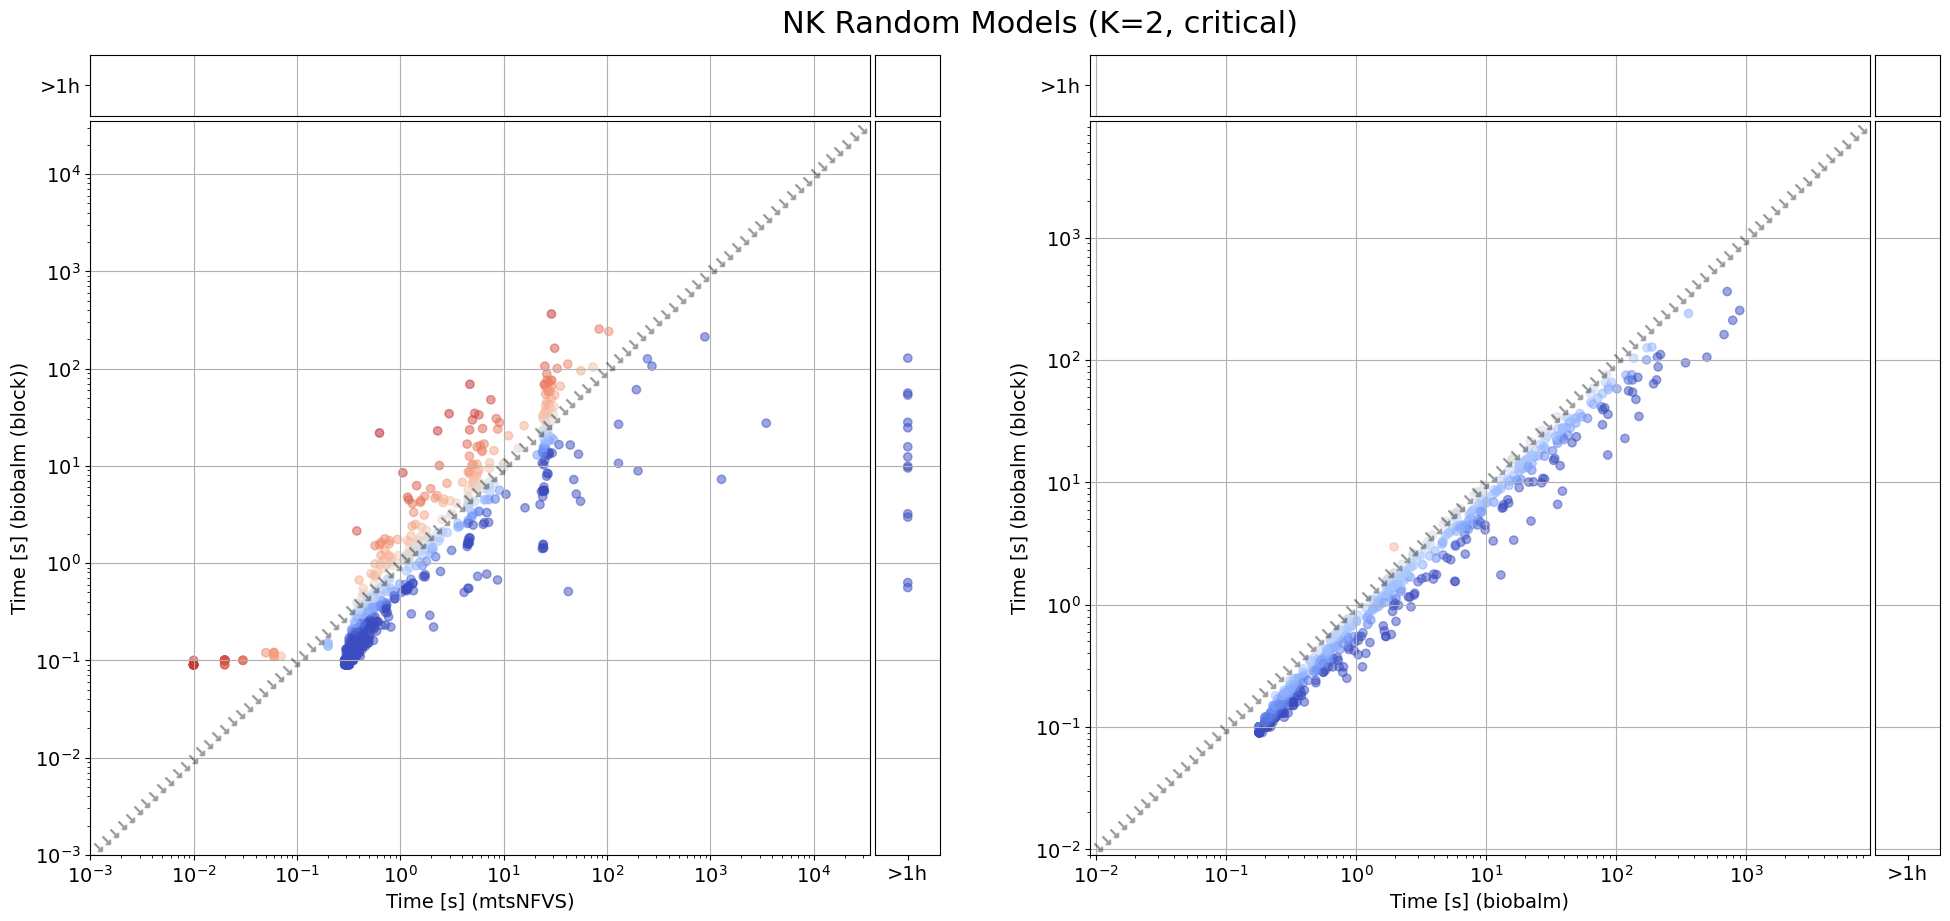

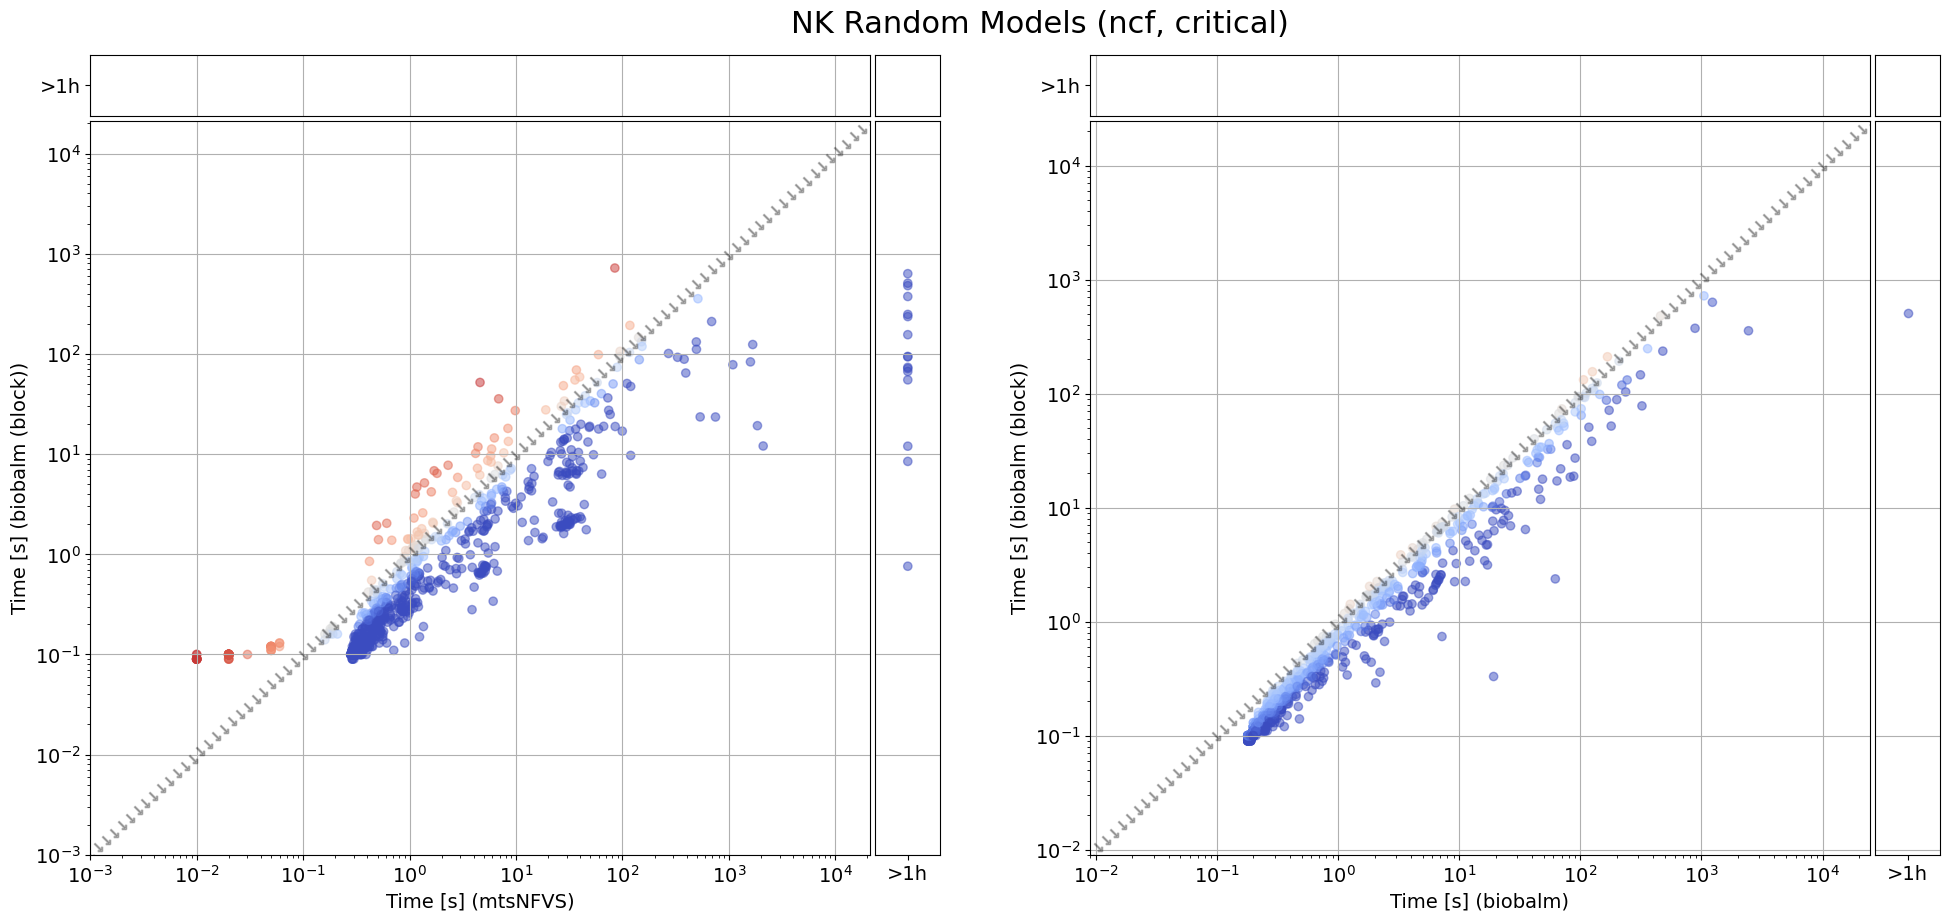

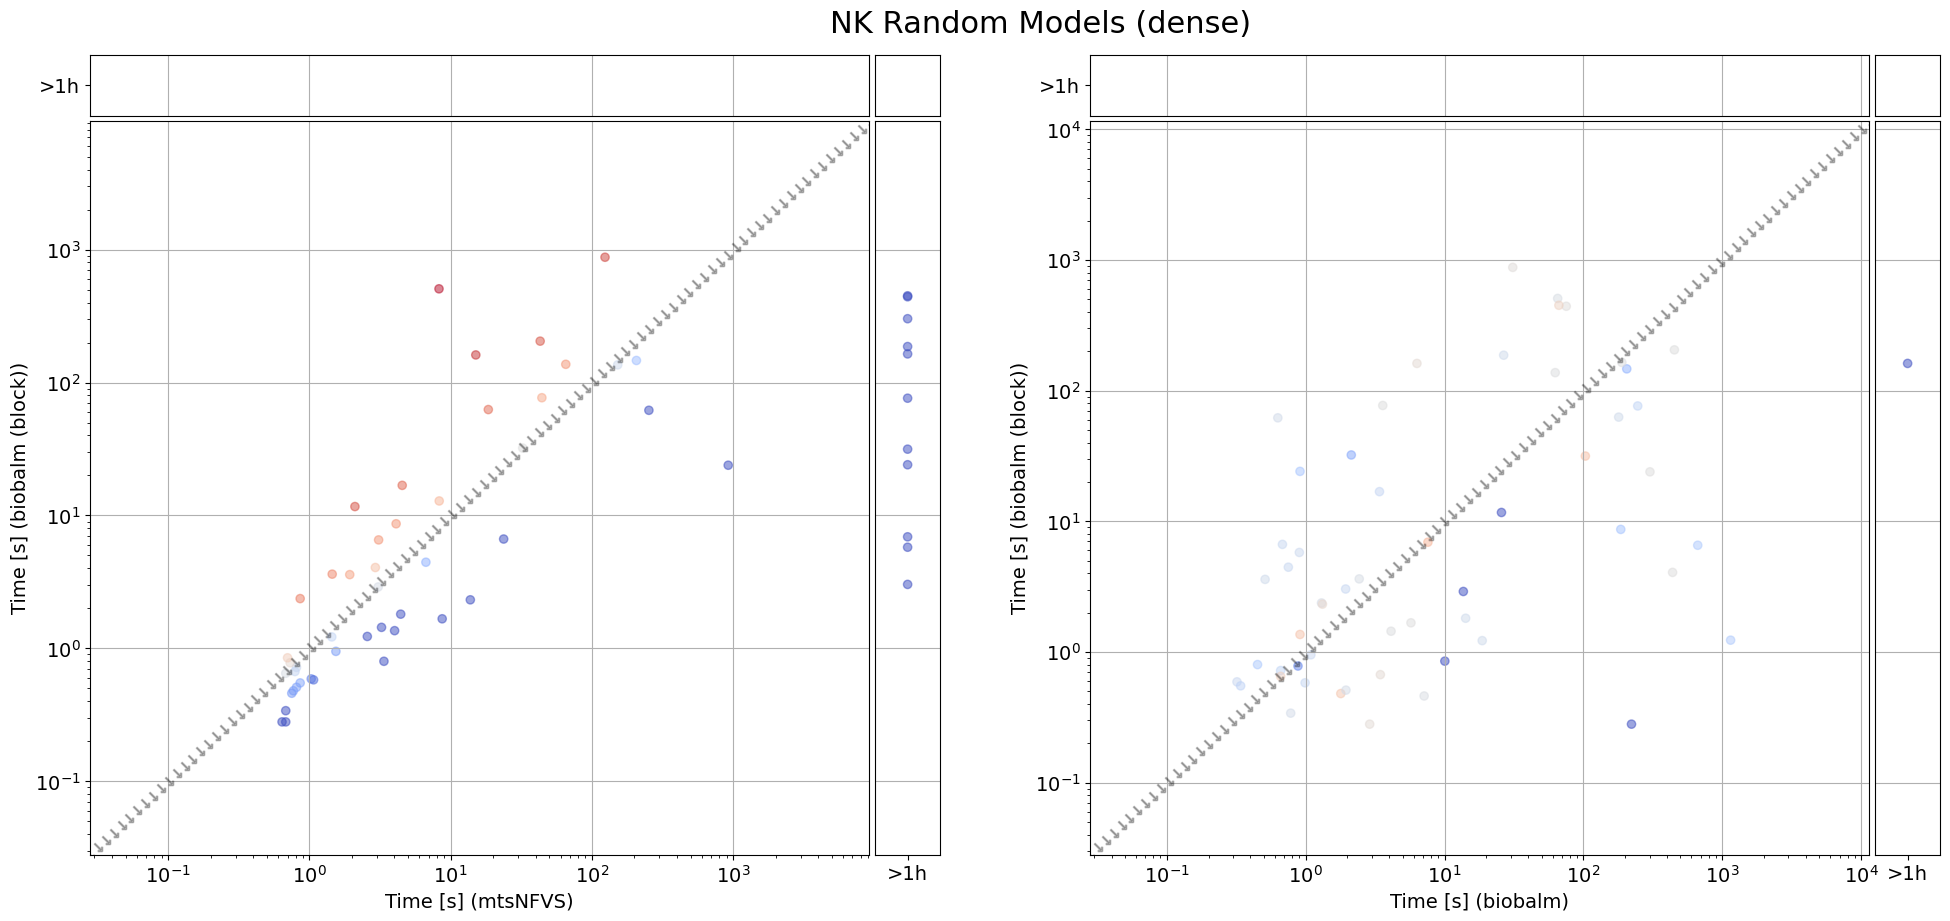

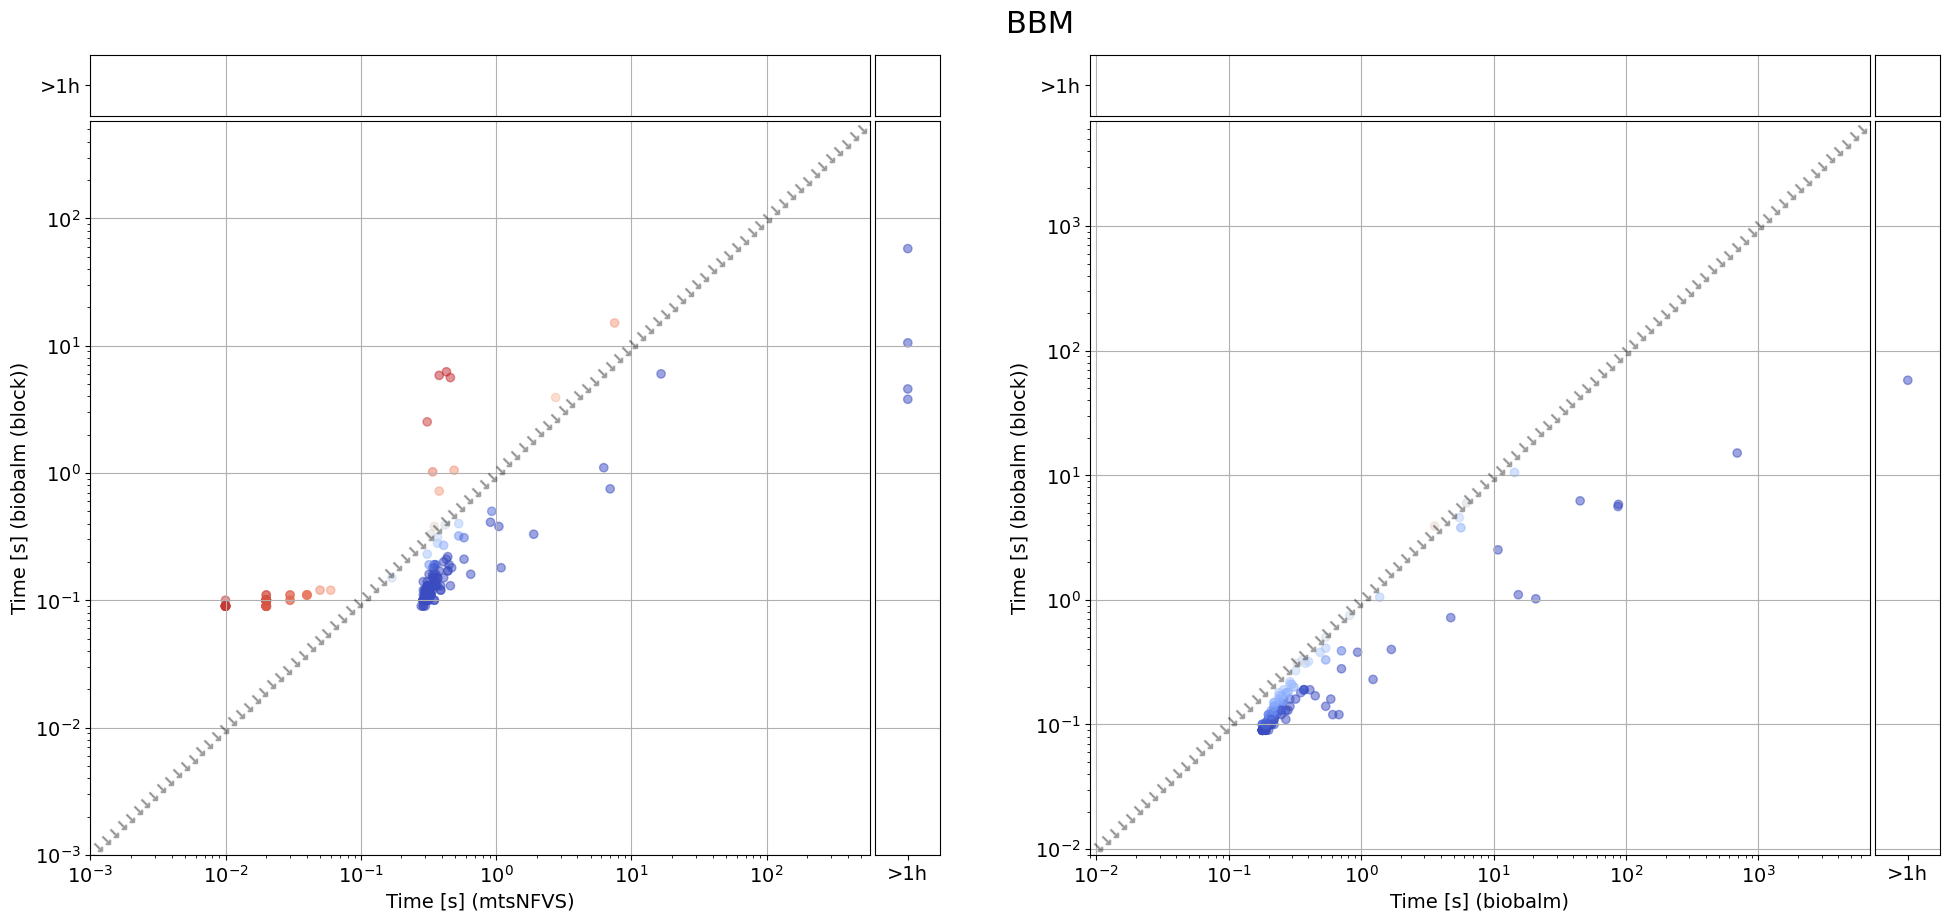

In [30]:
def plot_scatter(dirs, fnames, title=""):
    stretch_factor = 12
    fig = plt.figure(figsize=(20, 10))

    fig.set_facecolor("white")
    figs = fig.subfigures(1, 2)
    #for afig, tool in zip(figs.flatten(), ["mtsNFVS", "AEON.py"]):
    for afig, tool in zip(figs.flatten(), ["mtsNFVS", "biobalm"]):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if the note contains one of two pre-defined values.
            success_rows = df['Notes'].str.contains(r'Number of attractors|Network solved')
            df.loc[~success_rows, 'Time[s]'] = "inf"
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Attractors", "Attractor states"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if "Attractors" is exactly one number.
            success_rows = df['Attractors'].str.match(r'^\s*\d+$')
            print("Success rate for AEON:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "biobalm (block)":
            df = pd.read_csv(
                dirs[tool] + fnames["biobalm (block)"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined.
            success_rows = ~df['Attractors'].isna()
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps"],
            )
            success_rows = ~df_exp['Minimal traps'].isna()
            df_exp.loc[~success_rows, 'Time[s]'] = float("inf")
            df_exp["Time[s]"] = df_exp["Time[s]"].apply(lambda x: float(x))
            
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            
            # The benchmark is a success if "Attractors" is defined (if expansion failed, 
            # this will fail too, so no need to check both).
            success_rows = ~df_att['Attractors'].isna()
            df_att.loc[~success_rows, 'Time[s]'] = float("inf")
            df_att["Time[s]"] = df_att["Time[s]"].apply(lambda x: float(x))
            
            df.sort_values(by="Benchmark", inplace=True)
            t = df_exp["Time[s]"] + df_att["Time[s]"]
        
        df_compare = pd.read_csv(
            dirs["biobalm (block)"] + fnames["biobalm (block)"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
        )
        
        # The benchmark is a success if "Attractors" is defined.
        success_rows = ~df_compare['Attractors'].isna()
        df_compare.loc[~success_rows, 'Time[s]'] = float("inf")
        df_compare["Time[s]"] = df_compare["Time[s]"].apply(lambda x: float(x))
        
        df_compare.sort_values(by="Benchmark", inplace=True)
        t_bb = df_compare["Time[s]"]

        axd = afig.subplot_mosaic(
            [
                ["BBTimeout", "BothTimeout"],
                ["BothRan", "CompTimeout"],
            ],
            gridspec_kw={
                "width_ratios": [stretch_factor, 1],
                "height_ratios": [1, stretch_factor],
            },
        )

        axd["BothRan"].scatter(
            t,
            t_bb,
            c=t / t_bb,
            alpha=0.5,
            norm=CenteredNorm(vcenter=1, halfrange=1),
            cmap="coolwarm_r",
        )

        tmax = max(t[t < float("inf")].max(), t_bb[t_bb < float("inf")].max()) * 10.0
        tmin = min(t[t < float("inf")].min(), t_bb[t_bb < float("inf")].min()) / 10.0
        axd["BothRan"].set_xlim(tmin, tmax)
        axd["BothRan"].set_ylim(tmin, tmax)
        axd["BothRan"].set_xscale("log")
        axd["BothRan"].set_yscale("log")

        axd["BothRan"].set_xlabel(f"Time [s] ({tool})", fontsize=14)
        axd["BothRan"].set_ylabel("Time [s] (biobalm (block))", fontsize=14)
        axd["BothRan"].tick_params(labelsize=14, gridOn=True)

        boundary_pts = np.logspace(np.log10(tmin), np.log10(tmax), 100)
        axd["BothRan"].plot(
            boundary_pts,
            boundary_pts,
            color="black",
            linestyle="",
            marker=r"$\searrow$",
            alpha=0.25,
        )

        axd["BBTimeout"].scatter(
            t[t_bb == float("inf")],
            0 * t[t_bb == float("inf")],
            norm=CenteredNorm(vcenter=1, halfrange=0.5),
            c=0 * t[t_bb == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BBTimeout"].sharex(axd["BothRan"])
        axd["BBTimeout"].set_xscale("log")
        axd["BBTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["BBTimeout"].tick_params(axis="x", gridOn=True)
        axd["BBTimeout"].tick_params(axis="y", tick1On=True, labelleft=True)
        axd["BBTimeout"].set_yticks([0])
        axd["BBTimeout"].set_yticklabels([">1h"], fontsize=14)

        axd["CompTimeout"].scatter(
            0 * t_bb[t == float("inf")],
            t_bb[t == float("inf")],
            norm=CenteredNorm(vcenter=-1, halfrange=0.5),
            c=0 * t_bb[t == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["CompTimeout"].sharey(axd["BothRan"])
        axd["CompTimeout"].set_yscale("log")
        axd["CompTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["CompTimeout"].tick_params(axis="y", gridOn=True)
        axd["CompTimeout"].tick_params(axis="x", tick1On=True, labelbottom=True)
        axd["CompTimeout"].set_xticks([0])
        axd["CompTimeout"].set_xticklabels([">1h"], fontsize=14)

        axd["BothTimeout"].scatter(
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            norm=CenteredNorm(vcenter=0, halfrange=0.5),
            c=0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BothTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )

        afig.subplots_adjust(hspace=0.0135, wspace=0.0135)

    fig.subplots_adjust(bottom=0.08, left=0.05)
    fig.suptitle(title, fontsize=22, y=0.925)


plot_scatter(results_dirs, nk3_fnames, title="NK Random Models (K=3, critical)")
plot_scatter(results_dirs, nk2_fnames, title="NK Random Models (K=2, critical)")
plot_scatter(results_dirs, ncf_fnames, title="NK Random Models (ncf, critical)")
plot_scatter(results_dirs, dense_fnames, title="NK Random Models (dense)")
plot_scatter(results_dirs, bbm_fnames, title="BBM")